In [1]:
import math
import numpy as np
import os
import pandas as pd
import pysurvival
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from statistics import mean, stdev

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index, integrated_brier_score
from pysurvival.utils import save_model

from sklearn.model_selection import StratifiedKFold, KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lifelines import CoxPHFitter
import lifelines

# from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

In [ ]:
# Only need to run this once
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)
# utils.install_packages("survAUC")

### Feature Selection

In [2]:
def cox_feature_select(X, t, e):
    # Selecting features based on variance inflation factor and ranking based on hazard ratios
    # Number of features reduced unitl the ratio of features to events is 1:10
    num_samples = X.shape[0]
    num_events = sum(e)

    data_table = X
    data_table['Time'] = t
    data_table['Event'] = e

    max_num_features = math.ceil(num_events/10)
    cph = CoxPHFitter()
    cph.fit(data_table, duration_col='Time', event_col='Event')

    hr = abs(cph.params_)
    
    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1, len(index_names)):
        col_names.append(index_names[x])

    filtered_X = X.filter(items=col_names, axis=1)
    print("Cox filter remaining variables: \n", filtered_X.columns)

    return filtered_X

In [3]:
def calculate_vif(X, thresh=10):
    # Calculate the variance inflation factor of a feature
    variables = list(range(X.shape[1]))
    dropped=True

    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) \
               for ix in range(X.iloc[:, variables].shape[1])]
    
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            # print("Dropping \'" + X.iloc[:, variables].columns[maxloc] + "\' at index: "+ str(maxloc))
            del variables[maxloc]
            dropped = True
    
    print('VIF remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

### Model Creation and Training

In [4]:
def gh_c_index(risk_pred):
    """
    Calculate Gonen and Hiller's c-index using function from R (using rpy2) 

    Args:
        risk_pred: np.ndarray or torch.Tensor, risk score predictions from model

    Source: Gonen, M. and G. Heller (2005). 
    Concordance probability and discriminatory power in proportional hazards regression.
    Biometrika 92, 965–970.
    """

    # check for NaNs
    if not isinstance(risk_pred, np.ndarray):
        risk_pred = risk_pred.detach().cpu().numpy()
    for a in risk_pred:
        if np.isnan(a).any():
            raise ValueError("NaNs detected in inputs, please correct or drop.")

    # Use Gonen and Hiller's c-index via the survAUC library in R
    survAUC = rpackages.importr('survAUC')

    # Get data into right format
    R_risk_pred = robjects.vectors.FloatVector(risk_pred)

    # this doesn't work yet, need to get the list to numeric type
    # in R, this is accomplished with as.numeric and unlist()
    R_cind = survAUC.GHCI(R_risk_pred)

    # Convert back to Python list with single value
    cind = list(R_cind)

    # Return the only value in the cind list
    return cind[0]

In [5]:
def train_survival_model(X, t, e, num_trees, max_depth, min_node_size, seed=16):
    """
    Function to create and run Random Survival Forest with given attributes on data.

    Args:
        X: array -- input features, rows as samples
        t: array -- time labels for X, when event of interest or censoring occurred
        e: array -- event labels for X, if event occurred (1=event, 0=censoring)
        num_trees: int -- number of trees that will be built in forest model, used in initialization of model
        max_depth: int -- maximum number of levels allowed in tree, used in model fit
        min_node_size: int -- minimum number of samples required to be at leaf node, used in model fit
        seed: int -- random seed used by random number generator in model fit

    Returns: 
        rsf: pysurvival.model.RandomSurvivalForestModel -- model fit to input data
    """

    # Create instance of the model
    rsf = RandomSurvivalForestModel(num_trees=num_trees)

    # Fit model to data
    # Arguments not used from function input are defaults except importance_mode
    # TODO: need to find out what importance mode is 
    rsf.fit(X, t, e, max_features='all', max_depth=max_depth, min_node_size=min_node_size,
            num_threads=-1, sample_size_pct=0.63,
            seed=seed, save_memory=False)


    return rsf

In [6]:
def evaluate_forest(rsf, XT, tT, eT):
    bool_eT = eT.astype('bool')

    risk = rsf.predict_risk(XT)
    # h_c_ind = concordance_index_censored(bool_eT, tT, risk) # add [0] to h_c_ind in return line
    h_c_ind = lifelines.utils.concordance_index(tT, risk, eT)
    u_c_stat = concordance_index(rsf, XT, tT, eT)
    # gh_c_ind = gh_c_index(risk)
    ibs = integrated_brier_score(rsf, XT, tT, eT)

    return h_c_ind, u_c_stat, ibs, risk


In [7]:
def kfold_train_survival_model(X, t, e, num_trees, max_depth, min_node_size, k=5, seed=16):
    CI = []
    CPE = []
    IBS = []

    best_fold = 0
    best_CI = 0
    # best_GHCI = 0
    # best_IBS = 0 
    best_fold_rsf = None

    kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)

    history = {'train_CI': [], 'train_UnoC': [], 'train_IBS': [], 
               'valid_CI': [], 'valid_UnoC': [], 'valid_IBS': [],}
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, e)):
        # Output current fold number
        # print('Fold {}'.format(fold + 1))

        X_train, X_val = X.loc[train_idx], X.loc[val_idx]
        t_train, t_val = t.loc[train_idx], t.loc[val_idx]
        e_train, e_val = e.loc[train_idx], e.loc[val_idx]

        fold_rsf = train_survival_model(X_train, t_train, e_train, num_trees, max_depth, min_node_size, seed)

        train_h_c_ind, train_u_c_stat, train_ibs, train_risk_preds = evaluate_forest(fold_rsf, X_train, t_train, e_train)
        val_h_c_ind, val_u_c_stat, val_ibs, val_risk_preds = evaluate_forest(fold_rsf, X_val, t_val, e_val)

        # preds_and_labels = pd.DataFrame(train_risk_preds, columns=['Prediction'])

        history['train_CI'].append(train_h_c_ind)
        history['train_UnoC'].append(train_u_c_stat)
        history['train_IBS'].append(train_ibs)
        history['valid_CI'].append(val_h_c_ind)
        history['valid_UnoC'].append(val_u_c_stat)
        history['valid_IBS'].append(val_ibs)

        # Set best model based on the validation Uno's c statistic value
        if best_CI < val_u_c_stat:
            best_CI = val_u_c_stat
            best_fold = fold
            best_fold_rsf = fold_rsf

    
    train_CI_avg = mean(history['train_CI'])
    train_CI_std = stdev(history['train_CI'])
    train_UnoC_avg = mean(history['train_UnoC'])
    train_UnoC_std = stdev(history['train_UnoC'])
    train_IBS_avg = mean(history['train_IBS'])
    train_IBS_std = stdev(history['train_IBS'])

    valid_CI_avg = mean(history['valid_CI'])
    valid_CI_std = stdev(history['valid_CI'])
    valid_UnoC_avg = mean(history['valid_UnoC'])
    valid_UnoC_std = stdev(history['valid_UnoC'])
    valid_IBS_avg = mean(history['valid_IBS'])
    valid_IBS_std = stdev(history['valid_IBS'])



    avg_train_fold_results = {'CI_avg': train_CI_avg, 'CI_std': train_CI_std, 
                              'UnoC_avg': train_UnoC_avg, 'UnoC_std': train_UnoC_std,
                              'IBS_avg': train_IBS_avg, 'IBS_std': train_IBS_std}

    avg_valid_fold_results = {'CI_avg': valid_CI_avg, 'CI_std': valid_CI_std, 
                              'UnoC_avg': valid_UnoC_avg, 'UnoC_std': valid_UnoC_std,
                              'IBS_avg': valid_IBS_avg, 'IBS_std': valid_IBS_std}

    best_fold_results = {'train_CI': history['train_CI'][best_fold],
                         'train_UnoC': history['train_UnoC'][best_fold],
                         'train_IBS': history['train_IBS'][best_fold],
                         'valid_CI': history['valid_CI'][best_fold],
                         'valid_UnoC': history['valid_UnoC'][best_fold],
                         'valid_IBS': history['valid_IBS'][best_fold]}

    return avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf


# avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf = \
#                     kfold_train_survival_model(X_liver, t_liver, e_liver, num_trees=10, max_depth=6, min_node_size=15, k=5, seed=16)

In [8]:
def gridsearch_survival_model(X, t, e, tree_search, depth_search, node_search):
    """
    Function to run a gridsearch on various Random Survival Forest hyperparameters

    Args:
        X: array -- input features, rows as samples
        t: array -- time labels for X, when event of interest or censoring occurred
        e: array -- event labels for X, if event occurred (1=event, 0=censoring)
    """
    # Values to search through
    num_tree=tree_search
    max_depth=depth_search
    min_node=node_search

    # initialize variables to store best options
    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    curr_c_index_best = 0
    cpe_best = 0
    # ghci_best = 0
    avg_train_results = None
    avg_valid_results = None
    best_overall_results = None
    best_rsf = None


    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf = \
                    kfold_train_survival_model(X, t, e, num_trees=a, max_depth=b, min_node_size=c, k=5, seed=16)
                # print(best_fold_results['train_CI'], best_fold_results['valid_CI'])
                best_val_ci = best_fold_results['valid_UnoC']
                if best_val_ci > curr_c_index_best:
                    curr_c_index_best = best_val_ci
                    avg_train_results = avg_train_fold_results
                    avg_valid_results = avg_valid_fold_results
                    best_overall_results = best_fold_results
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    best_rsf = best_fold_rsf

    return num_tree_best, max_depth_best, min_node_best, avg_train_results, avg_valid_results, best_overall_results, best_rsf

# Main Script

### Liver

In [9]:
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_liver_data = pd.read_excel(os.path.join(data_folder, "train_liver_feats_and_labels.xlsx"))
test_liver_data = pd.read_excel(os.path.join(data_folder, "test_liver_feats_and_labels.xlsx"))

features_to_drop=[]
# features_to_drop = ['LeastAxisLength', '90Percentile', 'Contrast', 'MeshVolume', 'Complexity', 'MinorAxisLength', \
#                     '10Percentile', 'Uniformity', 'Mean', 'Energy', 'InterquartileRange', 'TotalEnergy', 'Busyness', \
#                     'RootMeanSquared', 'Maximum3DDiameter']

X_liver = train_liver_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_liver = X_liver.drop(labels=features_to_drop, axis=1)
t_liver = train_liver_data["HDFS_Time"]
e_liver = train_liver_data["HDFS_Code"]

XT_liver = test_liver_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_liver = XT_liver.drop(labels=features_to_drop, axis=1)
tT_liver = test_liver_data["HDFS_Time"]
eT_liver = test_liver_data["HDFS_Code"]

HCC_liver = test_liver_data[test_liver_data['Cancer_Type']==0]
HCC_Xliver = HCC_liver.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
HCC_tliver = HCC_liver["HDFS_Time"]
HCC_eliver = HCC_liver["HDFS_Code"]

MCRC_liver = test_liver_data[test_liver_data['Cancer_Type']==1]
MCRC_Xliver = MCRC_liver.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
MCRC_tliver = MCRC_liver["HDFS_Time"]
MCRC_eliver = MCRC_liver["HDFS_Code"]

ICC_liver = test_liver_data[test_liver_data['Cancer_Type']==2]
ICC_Xliver = ICC_liver.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
ICC_tliver = ICC_liver["HDFS_Time"]
ICC_eliver = ICC_liver["HDFS_Code"]

# CI_avg, GHCI_avg, IBS_avg, best_CI, best_GHCI, best_IBS, best_fold_rsf = kfold_train_survival_model(\
#     X_liver, t_liver, e_liver, num_trees=5, max_depth=5, min_node_size=5, k=5, seed=16)


In [62]:
liver_vselected_features = calculate_vif(X_liver, 10)
X_liver = liver_vselected_features

X_liver = cox_feature_select(X_liver, t_liver, e_liver)


/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['Kurtosis', 'Skewness', 'Variance', 'Busyness', 'Coarseness',
       'Complexity', 'Contrast', 'Strength', 'Flatness', 'SurfaceArea'],
      dtype='object')
Cox filter remaining variables: 
 Index(['Contrast', 'Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness',
       'Complexity', 'Variance', 'SurfaceArea'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Coarseness', 'Contrast'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [64]:
X_liver.drop(labels=['Contrast'], inplace=True, axis=1)
print(X_liver.columns)

Index(['Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness',
       'Complexity', 'Variance', 'SurfaceArea'],
      dtype='object')


In [10]:
X_liver = X_liver.filter(items=['Contrast', 'Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness','Complexity', 'Variance', 'SurfaceArea'], axis=1)

In [11]:
# X_liver = X_liver.filter(items=['Skewness', 'SurfaceArea', 'Variance', 'Contrast', \
#     'Kurtosis', 'Flatness', 'Complexity', 'Busyness', 'Strength'], axis=1)

avg_train_fold_results, avg_valid_fold_results, liv_best_fold_results, liv_best_fold_rsf = \
                    kfold_train_survival_model(X_liver, t_liver, e_liver, num_trees=8, max_depth=5, min_node_size=15, k=5, seed=16)

liver_h_c_ind, liver_u_c_stat, liver_ibs, liver_riskpreds = evaluate_forest(liv_best_fold_rsf, XT_liver, tT_liver, eT_liver)

liverhcc_h_c_ind, liverhcc_u_c_stat, liverhcc_ibs, liverhcc_riskpreds = evaluate_forest(liv_best_fold_rsf, HCC_Xliver, HCC_tliver, HCC_eliver)
livericc_h_c_ind, livericc_u_c_stat, livericc_ibs, livericc_riskpreds = evaluate_forest(liv_best_fold_rsf, ICC_Xliver, ICC_tliver, ICC_eliver)
livermcrc_h_c_ind, livermcrc_u_c_stat, livermcrc_ibs, livermcrc_riskpreds = evaluate_forest(liv_best_fold_rsf, MCRC_Xliver, MCRC_tliver, MCRC_eliver)

print("Overall Uno C:", liver_u_c_stat)
print("HCC Uno C:", liverhcc_u_c_stat)
print("ICC Uno C:", livericc_u_c_stat)
print("MCRC Uno C:", livermcrc_u_c_stat)

Overall Uno C: 0.542614371699287
HCC Uno C: 0.5123817712811694
ICC Uno C: 0.6368243243243243
MCRC Uno C: 0.5234499337001031


In [26]:
df_liver_confidence = pd.DataFrame(columns=['UnoC'])

for x in range(1000):
    samp_liver = test_liver_data.sample(test_liver_data.shape[0], replace=True)

    X_sampliver = samp_liver.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
    X_sampliver = X_sampliver.filter(items=['Contrast', 'Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness','Complexity', 'Variance', 'SurfaceArea'], axis=1)
    t_sampliver = samp_liver["HDFS_Time"]
    e_sampliver = samp_liver["HDFS_Code"]

    _, sampliver_u_c_stat, _, _ = evaluate_forest(liv_best_fold_rsf, X_sampliver, t_sampliver, e_sampliver)
    
    df_liver_confidence.loc[x] = sampliver_u_c_stat


df_liver_confidence.to_excel(os.path.join(data_folder, "RSF_liver_unoC_confidence_050722.xlsx"), index=False)

In [25]:
df_liver_confidence

,UnoC
0,0.636882
1,0.557015
2,0.558601
3,0.549818
4,0.640180


In [15]:
save_model(liv_best_fold_rsf, '/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/liver_rsf_model_050722.zip')

Saving the model to disk as /Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/liver_rsf_model_050722.zip


/opt/conda/lib/python3.8/site-packages/pysurvival/utils/__init__.py:132: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  model.save(path_file)


In [69]:
num_tree=(8, 10, 12)
max_depth=(5, 6, 8)
min_node=(12, 15, 18)


liv_num_tree_best, liv_max_depth_best, liv_min_node_best, \
    liv_avg_train_results, liv_avg_valid_results, liv_best_overall_results, liv_best_fold_rsf \
        = gridsearch_survival_model(X_liver, t_liver, e_liver, num_tree, max_depth, min_node)

print("Best valid c-index:", liv_best_overall_results['valid_CI'])
print("Best valid c-statistic", liv_best_overall_results['valid_UnoC'])
print("Best num_tree val:",liv_num_tree_best)
print("Best max_depth val:", liv_max_depth_best)
print("Best min_node val:",liv_min_node_best)

liver_h_c_ind, liver_u_c_stat, liver_ibs, liver_riskpreds = evaluate_forest(liv_best_fold_rsf, XT_liver, tT_liver, eT_liver)

print("Training: ")
print("Harrel's C-index: ", liv_best_overall_results['train_CI'])
print("Uno C-statistic: ", liv_best_overall_results['train_UnoC'])
print("IBS: ", liv_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", liv_best_overall_results['valid_CI'])
print("Uno C-statistic: ", liv_best_overall_results['valid_UnoC'])
print("IBS: ", liv_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", liver_h_c_ind)
print("Uno C-statistic: ", liver_u_c_stat)
print("IBS: ", liver_ibs)

liverhcc_h_c_ind, liverhcc_u_c_stat, liverhcc_ibs, liverhcc_riskpreds = evaluate_forest(liv_best_fold_rsf, HCC_Xliver, HCC_tliver, HCC_eliver)
livericc_h_c_ind, livericc_u_c_stat, livericc_ibs, livericc_riskpreds = evaluate_forest(liv_best_fold_rsf, ICC_Xliver, ICC_tliver, ICC_eliver)
livermcrc_h_c_ind, livermcrc_u_c_stat, livermcrc_ibs, livermcrc_riskpreds = evaluate_forest(liv_best_fold_rsf, MCRC_Xliver, MCRC_tliver, MCRC_eliver)

print()
print("HCC Uno C:", liverhcc_u_c_stat)
print("ICC Uno C:", livericc_u_c_stat)
print("MCRC Uno C:", livermcrc_u_c_stat)

liv_var_imps = liv_best_fold_rsf.variable_importance_table
liv_var_imps

Best valid c-index: 0.4004149377593361
Best valid c-statistic 0.6553052033598726
Best num_tree val: 10
Best max_depth val: 6
Best min_node val: 15
Training: 
Harrel's C-index:  0.2812454104861213
Uno C-statistic:  0.7200664793466427
IBS:  0.20149187032539329

Validation: 
Harrel's C-index:  0.4004149377593361
Uno C-statistic:  0.6553052033598726
IBS:  0.2167200297364266

Testing: 
Harrel's C-index:  0.4609053497942387
Uno C-statistic:  0.5434626903354786
IBS:  0.2365104499501027

HCC Uno C: 0.6971410146173689
ICC Uno C: 0.6330236486486487
MCRC Uno C: 0.5090615127123532


,feature,importance,pct_importance
0,Skewness,1.493359,0.357049
1,Strength,1.316322,0.314721
2,SurfaceArea,1.315219,0.314457
3,Flatness,0.057603,0.013772
4,Busyness,-0.179464,0.000000
5,Variance,-0.464733,0.000000
6,Kurtosis,-0.966410,0.000000
7,Complexity,-2.397426,0.000000


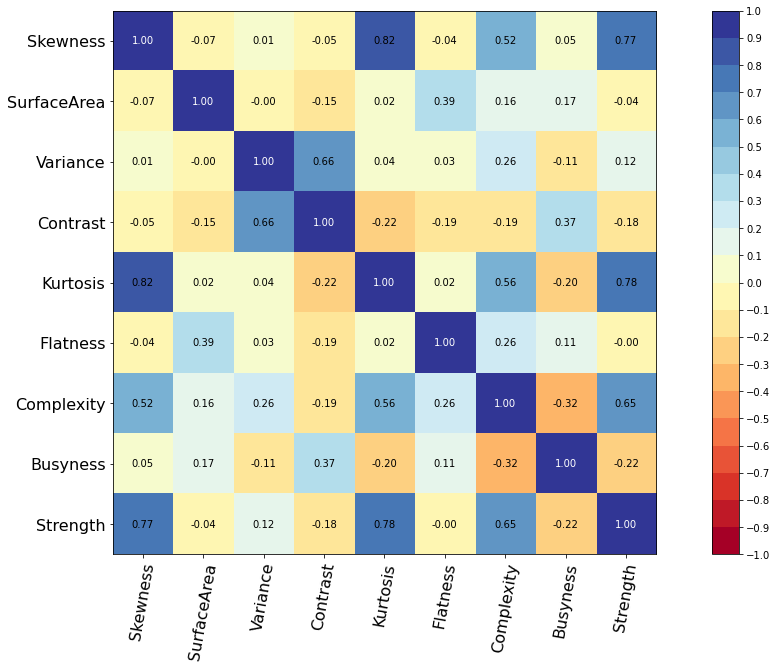

In [39]:
correlation_matrix(X_liver, figure_size=(20,10), text_fontsize=10)

In [40]:
test_liver_predictions = test_liver_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_liver_predictions['Prediction'] = liver_riskpreds
test_liver_predictions.to_excel(os.path.join(data_folder, "RSF_test_liver_predictions_90_10_050722.xlsx"), index=False)

### Tumor

In [29]:
# Data Loading and Setup
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_tumor_data = pd.read_excel(os.path.join(data_folder, "train_tumor_feats_and_labels.xlsx"))
test_tumor_data = pd.read_excel(os.path.join(data_folder, "test_tumor_feats_and_labels.xlsx"))

features_to_drop = []
# features_to_drop = ['SurfaceVolumeRatio', 'Maximum2DDiameterSlice', 'MajorAxisLength', 'Busyness', 'VoxelVolume',\
                    # '90Percentile', 'Median', 'Energy', 'RootMeanSquared']

X_tumor = train_tumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_tumor = X_tumor.drop(labels=features_to_drop, axis=1)
t_tumor = train_tumor_data["HDFS_Time"]
e_tumor = train_tumor_data["HDFS_Code"]

XT_tumor = test_tumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_tumor = XT_tumor.drop(labels=features_to_drop, axis=1)
tT_tumor = test_tumor_data["HDFS_Time"]
eT_tumor = test_tumor_data["HDFS_Code"]

HCC_tumor = test_tumor_data[test_tumor_data['Cancer_Type']==0]
HCC_Xtumor = HCC_tumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
HCC_ttumor = HCC_tumor["HDFS_Time"]
HCC_etumor = HCC_tumor["HDFS_Code"]

MCRC_tumor = test_tumor_data[test_tumor_data['Cancer_Type']==1]
MCRC_Xtumor = MCRC_tumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
MCRC_ttumor = MCRC_tumor["HDFS_Time"]
MCRC_etumor = MCRC_tumor["HDFS_Code"]

ICC_tumor = test_tumor_data[test_tumor_data['Cancer_Type']==2]
ICC_Xtumor = ICC_tumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
ICC_ttumor = ICC_tumor["HDFS_Time"]
ICC_etumor = ICC_tumor["HDFS_Code"]

In [32]:
# Feature selection
tum_vselected_features = calculate_vif(X_tumor, 10)
X_tumor = tum_vselected_features

X_tumor = cox_feature_select(X_tumor, t_tumor, e_tumor)


/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['10Percentile', 'Kurtosis', 'Minimum', 'TotalEnergy', 'Busyness',
       'Coarseness', 'Complexity', 'Contrast', 'Strength', 'Flatness',
       'Maximum2DDiameterColumn', 'MeshVolume'],
      dtype='object')
Cox filter remaining variables: 
 Index(['Contrast', 'Flatness', 'Strength', 'Maximum2DDiameterColumn',
       '10Percentile', 'Kurtosis', 'Busyness', 'Complexity', 'Minimum',
       'MeshVolume', 'TotalEnergy'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Coarseness'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [30]:
X_tumor = X_tumor.filter(items=['Kurtosis', 'Maximum2DDiameterColumn', 'Strength', 'MeshVolume', 'Contrast', 'Flatness'], axis=1)
X_tumor.columns

Index(['Kurtosis', 'Maximum2DDiameterColumn', 'Strength', 'MeshVolume',
       'Contrast', 'Flatness'],
      dtype='object')

In [28]:
X_tumor = X_tumor.filter(items=['Kurtosis', 'TotalEnergy', 'Maximum2DDiameterColumn', '10Percentile', 'MeshVolume'], axis=1)

In [32]:
avg_train_fold_results, avg_valid_fold_results, tum_best_fold_results, tum_best_fold_rsf = \
                    kfold_train_survival_model(X_tumor, t_tumor, e_tumor, num_trees=5, max_depth=10, min_node_size=10, k=5, seed=16)

tumor_h_c_ind, tumor_u_c_stat, tumor_ibs, tumor_riskpreds = evaluate_forest(tum_best_fold_rsf, XT_tumor, tT_tumor, eT_tumor)

tumorrhcc_h_c_ind, tumorhcc_u_c_stat, tumorhcc_ibs, tumorhcc_riskpreds = evaluate_forest(tum_best_fold_rsf, HCC_Xtumor, HCC_ttumor, HCC_etumor)
tumoricc_h_c_ind, tumoricc_u_c_stat, tumoricc_ibs, tumoricc_riskpreds = evaluate_forest(tum_best_fold_rsf, ICC_Xtumor, ICC_ttumor, ICC_etumor)
tumormcrc_h_c_ind, tumormcrc_u_c_stat, tumormcrc_ibs, tumormcrc_riskpreds = evaluate_forest(tum_best_fold_rsf, MCRC_Xtumor, MCRC_ttumor, MCRC_etumor)

print("Overall Uno C:", tumor_u_c_stat)
print("HCC Uno C:", tumorhcc_u_c_stat)
print("ICC Uno C:", tumoricc_u_c_stat)
print("MCRC Uno C:", tumormcrc_u_c_stat)

Overall Uno C: 0.53577033823638
HCC Uno C: 0.5424118658641445
ICC Uno C: 0.5912162162162162
MCRC Uno C: 0.5


In [35]:
df_tumor_confidence = pd.DataFrame(columns=['UnoC'])

for x in range(2000):
    samp_tumor = test_tumor_data.sample(test_tumor_data.shape[0], replace=True)

    X_samptumor = samp_tumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
    X_samptumor = X_samptumor.filter(items=['Kurtosis', 'Maximum2DDiameterColumn', 'Strength', 'MeshVolume','Contrast', 'Flatness'], axis=1)
    t_samptumor = samp_tumor["HDFS_Time"]
    e_samptumor = samp_tumor["HDFS_Code"]

    _, samptumor_u_c_stat, _, _ = evaluate_forest(tum_best_fold_rsf, X_samptumor, t_samptumor, e_samptumor)
    
    df_tumor_confidence.loc[x] = samptumor_u_c_stat


df_tumor_confidence.to_excel(os.path.join(data_folder, "RSF_tumor_unoC_confidence_050722.xlsx"), index=False)

In [38]:
# num_tree=(5, 10, 15, 20, 25)
# max_depth=(2, 4, 6, 8, 10)
# min_node=(5, 8, 10, 12, 15)

tum_num_tree=(5, 10, 15)
tum_max_depth=(5, 8, 10)
tum_min_node=(10, 12, 15)
# RSF Model creation and evaluation
tum_num_tree_best, tum_max_depth_best, tum_min_node_best, \
    tum_avg_train_results, tum_avg_valid_results, tum_best_overall_results, tum_best_fold_rsf \
        = gridsearch_survival_model(X_tumor, t_tumor, e_tumor, tum_num_tree, tum_max_depth, tum_min_node)

print("Best k-fold c-index:", tum_best_overall_results['valid_CI'])
# print(ghci_best)
print("Best num_tree val:",tum_num_tree_best)
print("Best max_depth val:", tum_max_depth_best)
print("Best min_node val:",tum_min_node_best)

# tumor_rsf = train_survival_model(X_tumor, t_tumor, e_tumor, num_trees=tum_num_tree_best, max_depth=tum_max_depth_best, min_node_size=tum_min_node_best, seed=16)
# train_tumor_cind, train_tumor_ghci, train_tumor_ibs, train_tumor_riskpred = evaluate_forest(tumor_rsf, X_tumor, t_tumor, e_tumor)
tumor_h_c_ind, tumor_u_c_stat, tumor_ibs, tumor_preds = evaluate_forest(tum_best_fold_rsf, XT_tumor, tT_tumor, eT_tumor)

print("Training: ")
print("Harrel's C-index: ", tum_best_overall_results['train_CI'])
print("Uno C-statistic: ", tum_best_overall_results['train_UnoC'])
print("IBS: ", tum_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", tum_best_overall_results['valid_CI'])
print("Uno's c-statistic: ", tum_best_overall_results['valid_UnoC'])
print("IBS: ", tum_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", tumor_h_c_ind)
print("Uno's c-statistic: ", tumor_u_c_stat)
print("IBS: ", tumor_ibs)

tumorhcc_h_c_ind, tumorhcc_u_c_stat, tumorhcc_ibs, tumorhcc_riskpreds = evaluate_forest(tum_best_fold_rsf, HCC_Xtumor, HCC_ttumor, HCC_etumor)
tumoricc_h_c_ind, tumoricc_u_c_stat, tumoricc_ibs, tumoricc_riskpreds = evaluate_forest(tum_best_fold_rsf, ICC_Xtumor, ICC_ttumor, ICC_etumor)
tumormcrc_h_c_ind, tumormcrc_u_c_stat, tumormcrc_ibs, tumormcrc_riskpreds = evaluate_forest(tum_best_fold_rsf, MCRC_Xtumor, MCRC_ttumor, MCRC_etumor)

print()
print("HCC Uno C:", tumorhcc_u_c_stat)
print("ICC Uno C:", tumoricc_u_c_stat)
print("MCRC Uno C:", tumormcrc_u_c_stat)

tum_var_imps = tum_best_fold_rsf.variable_importance_table
tum_var_imps

Best k-fold c-index: 0.34398340248962656
Best num_tree val: 5
Best max_depth val: 10
Best min_node val: 10
Training: 
Harrel's C-index:  0.25808978313017084
Uno C-statistic:  0.7416914117596562
IBS:  0.1692403772632824

Validation: 
Harrel's C-index:  0.34398340248962656
Uno's c-statistic:  0.6968342090795595
IBS:  0.19471160314936617

Testing: 
Harrel's C-index:  0.5342935528120714
Uno's c-statistic:  0.53577033823638
IBS:  0.2481674512960983

HCC Uno C: 0.5424118658641445
ICC Uno C: 0.5912162162162162
MCRC Uno C: 0.5


,feature,importance,pct_importance
0,MeshVolume,3.757565,0.348625
1,Maximum2DDiameterColumn,2.642792,0.245197
2,Kurtosis,2.073085,0.192340
3,Contrast,1.107522,0.102755
4,Flatness,0.902669,0.083749
5,Strength,0.294617,0.027334


In [42]:
test_tumor_predictions = test_tumor_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_tumor_predictions['Prediction'] = tumor_preds
test_tumor_predictions.to_excel(os.path.join(data_folder, "RSF_test_tumor_predictions_90_10_050722.xlsx"), index=False)

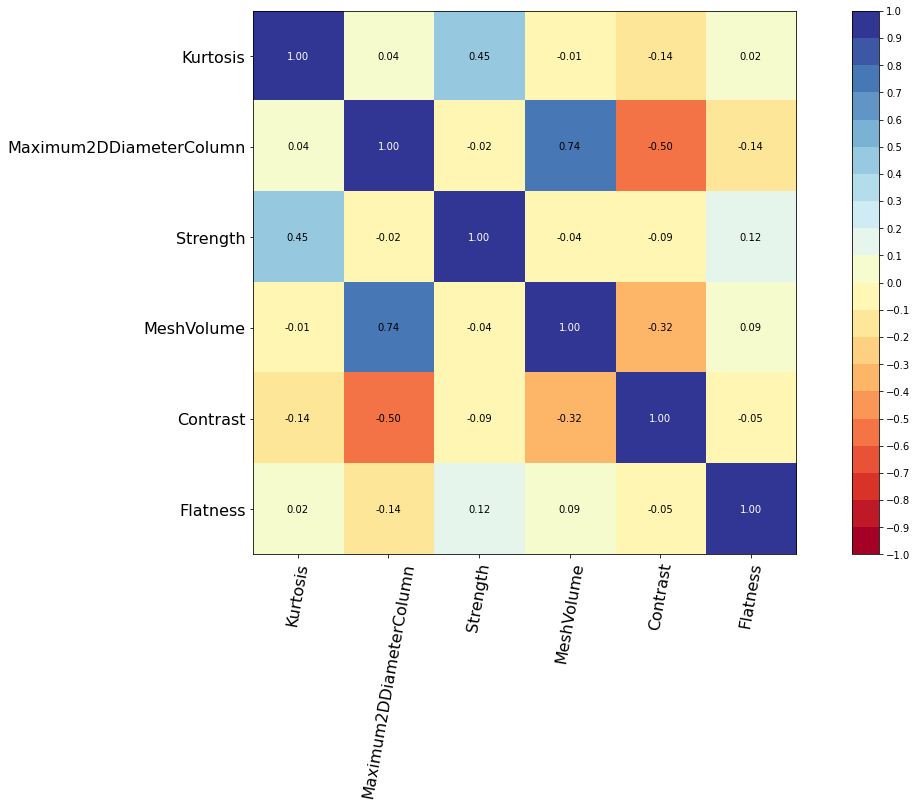

In [41]:
correlation_matrix(X_tumor, figure_size=(20,10), text_fontsize=10)

### Liver and Tumor

In [37]:
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_livertumor_data = pd.read_excel(os.path.join(data_folder, "train_liver_tumor_feats_and_labels.xlsx"))
test_livertumor_data = pd.read_excel(os.path.join(data_folder, "test_liver_tumor_feats_and_labels.xlsx"))

features_to_drop = []
# features_to_drop = ['Strength', 'MinorAxisLength', 'VoxelVolume', 'Complexity', 'Uniformity', 'Minimum', \
#                     'Median', 'InterquartileRange', 'Energy']

X_livertumor = train_livertumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_livertumor = X_livertumor.drop(labels=features_to_drop, axis=1)
t_livertumor = train_livertumor_data["HDFS_Time"]
e_livertumor = train_livertumor_data["HDFS_Code"]

XT_livertumor = test_livertumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_livertumor = XT_livertumor.drop(labels=features_to_drop, axis=1)
tT_livertumor = test_livertumor_data["HDFS_Time"]
eT_livertumor = test_livertumor_data["HDFS_Code"]

HCC_livertumor = test_livertumor_data[test_tumor_data['Cancer_Type']==0]
HCC_Xlivertumor = HCC_livertumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
HCC_tlivertumor = HCC_livertumor["HDFS_Time"]
HCC_elivertumor = HCC_livertumor["HDFS_Code"]

MCRC_livertumor = test_livertumor_data[test_tumor_data['Cancer_Type']==1]
MCRC_Xlivertumor = MCRC_livertumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
MCRC_tlivertumor = MCRC_livertumor["HDFS_Time"]
MCRC_elivertumor = MCRC_livertumor["HDFS_Code"]

ICC_livertumor = test_livertumor_data[test_tumor_data['Cancer_Type']==2]
ICC_Xlivertumor = ICC_livertumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
ICC_tlivertumor = ICC_livertumor["HDFS_Time"]
ICC_elivertumor = ICC_livertumor["HDFS_Code"]

In [45]:
livtum_vselected_features = calculate_vif(X_livertumor, 10)
X_livertumor = livtum_vselected_features

X_livertumor = cox_feature_select(X_livertumor, t_livertumor, e_livertumor)

/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['Kurtosis', 'Skewness', 'TotalEnergy', 'Variance', 'Busyness',
       'Complexity', 'Contrast', 'Strength', 'Flatness', 'SurfaceVolumeRatio'],
      dtype='object')
Cox filter remaining variables: 
 Index(['SurfaceVolumeRatio', 'Flatness', 'Skewness', 'Strength', 'Kurtosis',
       'Busyness', 'Complexity', 'Variance', 'TotalEnergy'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Contrast'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [24]:
X_livertumor.drop(labels=['Busyness'], inplace=True, axis=1)

In [38]:
X_livertumor = X_livertumor.filter(items=['SurfaceVolumeRatio', 'Flatness', 'Skewness', 'Strength', 'Kurtosis', 'Busyness', 'Complexity', 'Variance', 'TotalEnergy'], axis=1)

In [39]:
avg_train_fold_results, avg_valid_fold_results, livtum_best_fold_results, livtum_best_fold_rsf = \
                    kfold_train_survival_model(X_livertumor, t_livertumor, e_livertumor, num_trees=15, max_depth=8, min_node_size=15, k=5, seed=16)

livertumor_h_c_ind, livertumor_u_c_stat, livertumor_ibs, livertumor_riskpreds = evaluate_forest(livtum_best_fold_rsf, XT_livertumor, tT_livertumor, eT_livertumor)

livertumorrhcc_h_c_ind, livertumorhcc_u_c_stat, livertumorhcc_ibs, livertumorhcc_riskpreds = evaluate_forest(livtum_best_fold_rsf, HCC_Xlivertumor, HCC_tlivertumor, HCC_elivertumor)
livertumoricc_h_c_ind, livertumoricc_u_c_stat, livertumoricc_ibs, livertumoricc_riskpreds = evaluate_forest(livtum_best_fold_rsf, ICC_Xlivertumor, ICC_tlivertumor, ICC_elivertumor)
livertumormcrc_h_c_ind, livertumormcrc_u_c_stat, livertumormcrc_ibs, livertumormcrc_riskpreds = evaluate_forest(livtum_best_fold_rsf, MCRC_Xlivertumor, MCRC_tlivertumor, MCRC_elivertumor)

print("Overall Uno C:", livertumor_u_c_stat)
print("HCC Uno C:", livertumorhcc_u_c_stat)
print("ICC Uno C:", livertumoricc_u_c_stat)
print("MCRC Uno C:", livertumormcrc_u_c_stat)

Overall Uno C: 0.6543923284602665
HCC Uno C: 0.5391444539982804
ICC Uno C: 0.7415540540540542
MCRC Uno C: 0.5675950759485469


In [42]:
df_livertumor_confidence = pd.DataFrame(columns=['UnoC'])

for x in range(2000):
    samp_livertumor = test_livertumor_data.sample(test_livertumor_data.shape[0], replace=True)

    X_samplivertumor = samp_livertumor.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
    X_samplivertumor = X_samplivertumor.filter(items=['SurfaceVolumeRatio', 'Flatness', 'Skewness', 'Strength', 'Kurtosis', 'Busyness', 'Complexity', 'Variance', 'TotalEnergy'], axis=1)
    t_samplivertumor = samp_livertumor["HDFS_Time"]
    e_samplivertumor = samp_livertumor["HDFS_Code"]

    _, samplivertumor_u_c_stat, _, _ = evaluate_forest(livtum_best_fold_rsf, X_samplivertumor, t_samplivertumor, e_samplivertumor)
    
    df_livertumor_confidence.loc[x] = samplivertumor_u_c_stat


df_livertumor_confidence.to_excel(os.path.join(data_folder, "RSF_livertumor_unoC_confidence_050722.xlsx"), index=False)

In [58]:
livtum_num_tree=(10, 15, 18)
livtum_max_depth=(6, 8, 10)
livtum_min_node=(10, 15, 18)


livtum_num_tree_best, livtum_max_depth_best, livtum_min_node_best, \
    livtum_avg_train_results, livtum_avg_valid_results, livtum_best_overall_results, livtum_best_fold_rsf \
        = gridsearch_survival_model(X_livertumor, t_livertumor, e_livertumor, livtum_num_tree, livtum_max_depth, livtum_min_node)

print("Best k-fold c-index:", livtum_best_overall_results['valid_CI'])
# print(ghci_best)
print("Best num_tree val:",livtum_num_tree_best)
print("Best max_depth val:",livtum_max_depth_best)
print("Best min_node val:",livtum_min_node_best)

# livertumor_rsf = train_survival_model(X_livertumor, t_livertumor, e_livertumor, num_trees=livtum_num_tree_best, max_depth=livtum_max_depth_best, min_node_size=livtum_min_node_best, seed=16)

# train_livertumor_cind, train_livertumor_ghci, train_livertumor_ibs, train_livertumor_riskpred = evaluate_forest(livertumor_rsf, X_livertumor, t_livertumor, e_livertumor)

livertumor_h_c_ind, livertumor_u_c_stat, livertumor_ibs, livertumor_riskpreds = evaluate_forest(livtum_best_fold_rsf, XT_livertumor, tT_livertumor, eT_livertumor)

print("Training: ")
print("Harrel's C-index: ", livtum_best_overall_results['train_CI'])
print("Uno's C-statistic: ", livtum_best_overall_results['train_UnoC'])
print("IBS: ", livtum_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", livtum_best_overall_results['valid_CI'])
print("Uno's C-statistic: ", livtum_best_overall_results['valid_UnoC'])
print("IBS: ", livtum_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ",livertumor_h_c_ind)
print("Uno's C-statistic: ",livertumor_u_c_stat)
print("IBS: ",livertumor_ibs)

livertumorhcc_h_c_ind, livertumorhcc_u_c_stat, livertumorhcc_ibs, livertumorhcc_riskpreds = evaluate_forest(livtum_best_fold_rsf, HCC_Xlivertumor, HCC_tlivertumor, HCC_elivertumor)
livertumoricc_h_c_ind, livertumoricc_u_c_stat, livertumoricc_ibs, livertumoricc_riskpreds = evaluate_forest(livtum_best_fold_rsf, ICC_Xlivertumor, ICC_tlivertumor, ICC_elivertumor)
livertumormcrc_h_c_ind, livertumormcrc_u_c_stat, livertumormcrc_ibs, livertumormcrc_riskpreds = evaluate_forest(livtum_best_fold_rsf, MCRC_Xlivertumor, MCRC_tlivertumor, MCRC_elivertumor)

print()
print("HCC Uno C:", livertumorhcc_u_c_stat)
print("ICC Uno C:", livertumoricc_u_c_stat)
print("MCRC Uno C:", livertumormcrc_u_c_stat)

var_imps = livtum_best_fold_rsf.variable_importance_table
var_imps

Best k-fold c-index: 0.42697095435684645
Best num_tree val: 15
Best max_depth val: 8
Best min_node val: 15
Training: 
Harrel's C-index:  0.2781245410486121
Uno's C-statistic:  0.7262744590379283
IBS:  0.18895445021744584

Validation: 
Harrel's C-index:  0.42697095435684645
Uno's C-statistic:  0.6218986688015956
IBS:  0.23409473023905697

Testing: 
Harrel's C-index:  0.345679012345679
Uno's C-statistic:  0.6543923284602665
IBS:  0.22427030299999967

HCC Uno C: 0.5391444539982804
ICC Uno C: 0.7415540540540542
MCRC Uno C: 0.5675950759485469


,feature,importance,pct_importance
0,Skewness,2.414416,0.243958
1,TotalEnergy,1.861830,0.188123
2,Complexity,1.858667,0.187804
3,Strength,1.171081,0.118328
4,Kurtosis,1.098730,0.111018
5,Variance,0.899658,0.090903
6,Busyness,0.591369,0.059753
7,SurfaceVolumeRatio,0.001112,0.000112
8,Flatness,-1.651548,0.000000


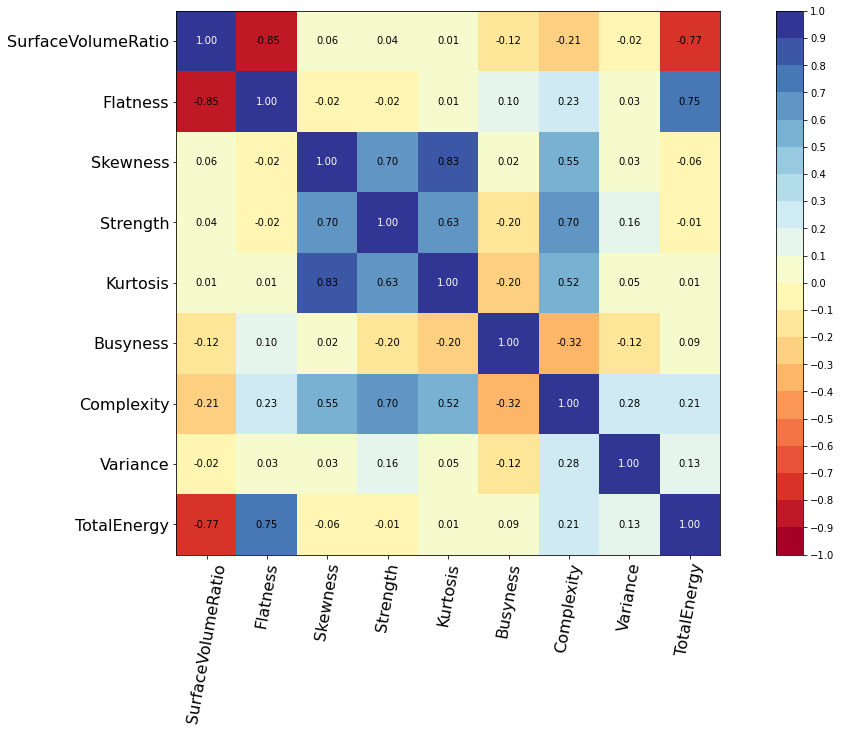

In [59]:
correlation_matrix(X_livertumor, figure_size=(20,10), text_fontsize=10)

In [60]:
test_livertumor_predictions = test_livertumor_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_livertumor_predictions['Prediction'] = livertumor_riskpreds
test_livertumor_predictions.to_excel(os.path.join(data_folder, "RSF_test_liver_tumor_predictions_80_20_050722.xlsx"), index=False)

# Other Code

In [ ]:
# correlation_matrix(X_liver, figure_size=(30,15), text_fontsize=10)

In [ ]:
print("Best valid c-index:", liv_best_overall_results['valid_CI'])
print("Best valid c-statistic", liv_best_overall_results['valid_UnoC'])
print("Best num_tree val:",liv_num_tree_best)
print("Best max_depth val:", liv_max_depth_best)
print("Best min_node val:",liv_min_node_best)

liver_h_c_ind, liver_u_c_stat, liver_ibs, liver_riskpreds = evaluate_forest(liv_best_fold_rsf, XT_liver, tT_liver, eT_liver)

print("Training: ")
print("Harrel's C-index: ", liv_best_overall_results['train_CI'])
print("Uno C-statistic: ", liv_best_overall_results['train_UnoC'])
print("IBS: ", liv_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", liv_best_overall_results['valid_CI'])
print("Uno C-statistic: ", liv_best_overall_results['valid_UnoC'])
print("IBS: ", liv_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", liver_h_c_ind)
print("Uno C-statistic: ", liver_u_c_stat)
print("IBS: ", liver_ibs)

liv_var_imps = liv_best_fold_rsf.variable_importance_table
liv_var_imps